In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 10))
train_y = Variable(torch.sign(torch.cos(train_x.data * (4 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.models.VariationalGP):
    def __init__(self, train_inputs):
        super(GPClassificationModel, self).__init__(train_inputs)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

    
model = GPClassificationModel(train_x.data)
likelihood = BernoulliLikelihood()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()

Iter 1/50 - Loss: 285.957   log_lengthscale: 0.000
Iter 2/50 - Loss: 198.650   log_lengthscale: -0.100
Iter 3/50 - Loss: 138.575   log_lengthscale: -0.200
Iter 4/50 - Loss: 89.964   log_lengthscale: -0.293
Iter 5/50 - Loss: 56.444   log_lengthscale: -0.387
Iter 6/50 - Loss: 31.271   log_lengthscale: -0.478
Iter 7/50 - Loss: 24.314   log_lengthscale: -0.567
Iter 8/50 - Loss: 22.223   log_lengthscale: -0.659
Iter 9/50 - Loss: 15.125   log_lengthscale: -0.753
Iter 10/50 - Loss: 11.434   log_lengthscale: -0.843
Iter 11/50 - Loss: 15.864   log_lengthscale: -0.931
Iter 12/50 - Loss: 15.044   log_lengthscale: -1.020
Iter 13/50 - Loss: 14.783   log_lengthscale: -1.109
Iter 14/50 - Loss: 10.466   log_lengthscale: -1.198
Iter 15/50 - Loss: 10.803   log_lengthscale: -1.283
Iter 16/50 - Loss: 10.204   log_lengthscale: -1.365
Iter 17/50 - Loss: 8.580   log_lengthscale: -1.443
Iter 18/50 - Loss: 10.007   log_lengthscale: -1.517
Iter 19/50 - Loss: 7.119   log_lengthscale: -1.589
Iter 20/50 - Loss: 2.

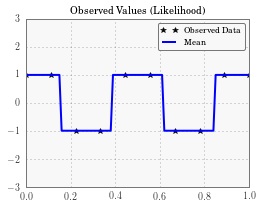

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 101))
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')